In [3]:
!pip install -q pandas numpy scikit-learn matplotlib seaborn kaggle


In [7]:
from google.colab import files
files.upload()


Saving archive.zip to archive (1).zip


{'archive (1).zip': b'PK\x03\x04-\x00\x00\x08\x08\x00\xeb\x83\xf0V^\xc4\x8c\x85\xff\xff\xff\xff\xff\xff\xff\xff\x19\x00\x14\x00loan_approval_dataset.csv\x01\x00\x10\x00Q\xdd\x05\x00\x00\x00\x00\x00\xabA\x01\x00\x00\x00\x00\x00\x84\xbd\xcb\xae,\xb9\xd1\x1d<7\xe0w\xd0\x03\xd4\x0f0\x93\x99\xcc\xcc\xe1?\xf2\xec\x0c<\xf3HhK\xc7\x80l\xa9\xfb\x83\xbae\xd8oo\x06\x93k\x05/\x8b\xa5\x06\x1a\xb5w\xd5\xd9\x91,2.+\x82q\xf9\xfbo\xbf\xfc\xfa\xe7\xbf\xfd\xf5\xf3\xa7_\x7f\xfb\xf3o\xff\xe3\xcf\x7f\xfd\xf9\x1f?\x7f\xfd\xeb\xcf_\xff\xf8\xfd\xf3\xa7\x9f\x7f\xfd\xd7_~\xf9\xe3o\xbf\xfd\xfa\xf9\xd3\xef?\xff\xfe?\xfe\xfc\xf3\x1f\xff\xf1\xf7\xdf\xfe\xef\xcf\xfco\xff\xf6\xeb_~\xfb\xc7\xcf?\xff\xf2\xeb\xaf\xff\xfa\xc7\xe7O\x85\xc4/\xff\xf8\xed_\xbf\xfeQ\x7f\xf9\xe3\xe7?\xf3\xfb\x7f\xf9\xdb\x7f\xff\xdb\xdf\xff\xfc\xfb_~\xfb\xe7\xcf\xcf\x9f\xfe\xf9\xf3\xf7\xbf\x19\xdd\xbf\xfd\xf2\xf7?\xff\xf2\xfb\xef?\xff\xf8\xfd\xcf\xff\xfb\x97\xbf\xff+\x7f\x92I\xfd\xe3\xe7?\xff2\x7f\xf0\xf7\x7f\xfd\x9f\x7f\xfd\xf3\xff\x0eo\xfe\xf7

In [9]:
!unzip -o archive.zip -d /content
!ls -lh /content

Archive:  archive.zip
  inflating: /content/loan_approval_dataset.csv  
total 548K
-rw-r--r-- 1 root root  81K Aug 25 12:14 'archive (1).zip'
-rw-r--r-- 1 root root  81K Aug 25 12:12  archive.zip
-rw-r--r-- 1 root root 376K Jul 16  2023  loan_approval_dataset.csv
drwxr-xr-x 1 root root 4.0K Aug 21 13:41  sample_data


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE



In [13]:
df = pd.read_csv("/content/loan_approval_dataset.csv")

# Normalize headers: strip whitespace, lower-case, replace spaces with underscores
df.columns = (df.columns
              .str.encode('utf-8', 'ignore').str.decode('utf-8')
              .str.strip()
              .str.lower()
              .str.replace(r'\s+', '_', regex=True))

print("Shape:", df.shape)
print("\nColumns (normalized):")
print(df.columns.tolist())

print("\nHead:")
display(df.head())

print("\nDtypes:")
print(df.dtypes)

# Verify target column exists and show distribution
if 'loan_status' not in df.columns:
    raise KeyError(f"'loan_status' not found. Available columns: {df.columns.tolist()}")

print("\nClass distribution:")
print(df['loan_status'].value_counts(dropna=False))


Shape: (4269, 13)

Columns (normalized):
['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']

Head:


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected



Dtypes:
loan_id                      int64
no_of_dependents             int64
education                   object
self_employed               object
income_annum                 int64
loan_amount                  int64
loan_term                    int64
cibil_score                  int64
residential_assets_value     int64
commercial_assets_value      int64
luxury_assets_value          int64
bank_asset_value             int64
loan_status                 object
dtype: object

Class distribution:
loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


In [20]:
# Clean target column (strip spaces and lowercase everything)
df['loan_status'] = df['loan_status'].str.strip().str.lower()

# Map target
y = df['loan_status'].map({'approved': 1, 'rejected': 0})

# Drop rows where target is missing
mask = y.notna()
X = df.loc[mask].drop(columns=['loan_status', 'loan_id'])
y = y.loc[mask]

# Split categorical vs numerical
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

print("Rows after cleaning:", len(X))
print("Target distribution:\n", y.value_counts())


Rows after cleaning: 4269
Target distribution:
 loan_status
1    2656
0    1613
Name: count, dtype: int64


In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing for categorical and numeric
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (3415, 11) Test shape: (854, 11)


In [22]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train & evaluate
for name, model in models.items():
    print(f"\n=== {name} ===")
    pipe = Pipeline(steps=[('preprocess', preprocessor),
                           ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.903     0.867     0.885       323
           1      0.921     0.944     0.932       531

    accuracy                          0.915       854
   macro avg      0.912     0.905     0.908       854
weighted avg      0.914     0.915     0.914       854


=== Decision Tree ===
              precision    recall  f1-score   support

           0      0.984     0.975     0.980       323
           1      0.985     0.991     0.988       531

    accuracy                          0.985       854
   macro avg      0.985     0.983     0.984       854
weighted avg      0.985     0.985     0.985       854


=== Random Forest ===
              precision    recall  f1-score   support

           0      0.972     0.972     0.972       323
           1      0.983     0.983     0.983       531

    accuracy                          0.979       854
   macro avg      0.978     0.978     0.978       854

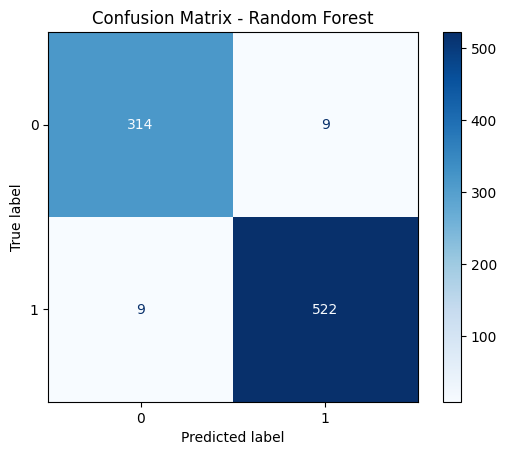

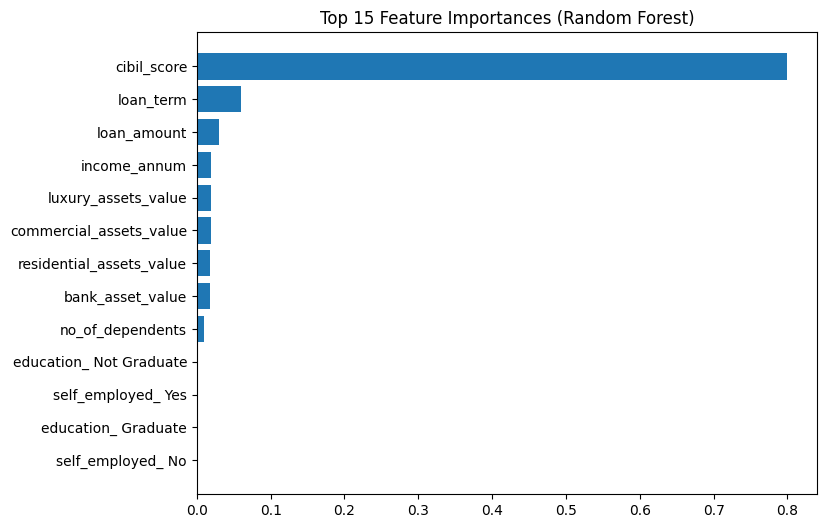

In [23]:
# ✅ Confusion Matrix for Random Forest (best among tree models usually)
best_model = RandomForestClassifier(random_state=42)
pipe = Pipeline(steps=[('preprocess', preprocessor),
                       ('model', best_model)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ✅ Feature Importance (from Random Forest)
# Need to extract feature names after preprocessing
onehot_features = pipe.named_steps['preprocess'].transformers_[0][1].get_feature_names_out(cat_cols)
all_features = list(onehot_features) + num_cols

importances = pipe.named_steps['model'].feature_importances_
indices = np.argsort(importances)[-15:]  # top 15 features

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

In [26]:
# Apply preprocessing first (without model)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# ✅ Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

print("Original training set shape:", y_train.value_counts())
print("Resampled training set shape:", y_train_res.value_counts())

# Train models again after SMOTE
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    print(f"\n=== {name} with SMOTE ===")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_transformed)
    print(classification_report(y_test, y_pred, digits=3))


Original training set shape: loan_status
1    2125
0    1290
Name: count, dtype: int64
Resampled training set shape: loan_status
1    2125
0    2125
Name: count, dtype: int64

=== Logistic Regression with SMOTE ===
              precision    recall  f1-score   support

           0      0.879     0.923     0.900       323
           1      0.951     0.923     0.937       531

    accuracy                          0.923       854
   macro avg      0.915     0.923     0.919       854
weighted avg      0.924     0.923     0.923       854


=== Decision Tree with SMOTE ===
              precision    recall  f1-score   support

           0      0.981     0.969     0.975       323
           1      0.981     0.989     0.985       531

    accuracy                          0.981       854
   macro avg      0.981     0.979     0.980       854
weighted avg      0.981     0.981     0.981       854


=== Random Forest with SMOTE ===
              precision    recall  f1-score   support

        